In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

plt.rcParams.update({
    "figure.dpi": 100,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [14]:
def load_judgments_from_directory(directory_path):
    """
    Load all YAML judgment files from a directory into a pandas DataFrame.
    
    Args:
        directory_path: Path to directory containing *_judgment.yaml files
        
    Returns:
        DataFrame with all judgment data
    """
    dir_path = Path(directory_path)
    
    # Find all judgment YAML files
    yaml_files = list(dir_path.rglob('*_judgment.yaml'))
    print(f"Found {len(yaml_files)} judgment files in {directory_path}")
    
    records = []
    
    for yaml_file in yaml_files:
        try:
            with open(yaml_file, 'r', encoding='utf-8') as f:
                data = yaml.safe_load(f)
            
            # Extract judgment fields
            judgment = data.get('judgment', {})
            
            # Extract prompt_category from file path for trust vec types
            # Path structure: .../vec_type/dataset/prompt_category/L_X_S_Y/file.yaml
            prompt_category = None
            vec_type = data.get('vec_type')
            
            if vec_type in ['trust_complete', 'trust_orthogonal']:
                # Get parent directories
                parts = yaml_file.parts
                # Find the dataset in the path
                dataset = data.get('dataset')
                if dataset:
                    try:
                        dataset_idx = parts.index(dataset)
                        # prompt_category is the next directory after dataset
                        if dataset_idx + 1 < len(parts):
                            prompt_category = parts[dataset_idx + 1]
                    except (ValueError, IndexError):
                        pass
            
            # Create record with metadata and judgment fields
            record = {
                'model': data.get('model'),
                'vec_type': data.get('vec_type'),
                'dataset': data.get('dataset'),
                'prompt_category': prompt_category,
                'layer_id': data.get('layer_id'),
                'strength': data.get('strength'),
                'judge_model': data.get('judge_model'),
                'prompt_id': data.get('prompt_id'),
                'category': data.get('category'),
                'prompt': data.get('prompt'),
                'model_response': data.get('model_response'),
                'model_response_parsed': data.get('model_response_parsed'),
                'file_path': str(yaml_file)
            }
            
            # Add all judgment fields (is_refusal, is_faithful_answer, etc.)
            record.update(judgment)
            
            records.append(record)
            
        except Exception as e:
            print(f"Error loading {yaml_file}: {e}")
            continue
    
    df = pd.DataFrame(records)
    print(f"\nLoaded {len(df)} judgments into DataFrame")
    print(f"\nColumns: {df.columns.tolist()}")
    
    return df

In [15]:
def create_vector_label(row):
    strength = row.get('strength', None)
    prompt_category = row.get('prompt_category', None)
    vec_type = row.get('vec_type', None)
    
    # Handle random FIRST
    if isinstance(strength, str) and 'random' in strength:
        return 'random'
        
    if isinstance(vec_type, str) and 'refusal' in vec_type:
        return 'compliance'
    
    # Handle prompt category
    if pd.notna(prompt_category):
        return f"{row['vec_type']}_{prompt_category}"

    return row['vec_type']

In [16]:
# Example: Load all judgments from a specific directory
base_dir = "../outputs/judge_outputs/openai_gpt-oss-120b"
df = load_judgments_from_directory(base_dir)

# Create vector labels
df['vector_label'] = df.apply(create_vector_label, axis=1)

Found 5990 judgment files in ../outputs/judge_outputs/openai_gpt-oss-120b

Loaded 5990 judgments into DataFrame

Columns: ['model', 'vec_type', 'dataset', 'prompt_category', 'layer_id', 'strength', 'judge_model', 'prompt_id', 'category', 'prompt', 'model_response', 'model_response_parsed', 'file_path', 'reasoning', 'is_refusal', 'is_faithful_answer', 'contains_restricted_content', 'compliance_style', 'is_evasive', 'final_verdict', 'rationalizes_bad_to_good', 'twists_good_to_bad']


In [17]:
# Inspect the data
print(f"Shape: {df.shape}")
print(f"\nDatasets: {df['dataset'].unique()}")
print(f"Vector labels: {sorted(df['vector_label'].unique())}")
print(f"\nFirst few rows:")
df[['dataset', 'vec_type', 'prompt_category', 'vector_label', 'strength']]

Shape: (5990, 23)

Datasets: ['wildjb_benign' 'harmful' 'user_description_single'
 'user_description_open' 'harmful_hhh' 'harmful_trust']
Vector labels: ['compliance', 'control', 'random', 'trust_complete_no_refusal', 'trust_complete_refusal', 'trust_orthogonal_no_refusal', 'trust_orthogonal_refusal']

First few rows:


,dataset,vec_type,prompt_category,vector_label,strength
0,wildjb_benign,refusal,None,compliance,-1.0
1,wildjb_benign,refusal,None,compliance,-1.0
2,wildjb_benign,refusal,None,compliance,-1.0
3,wildjb_benign,refusal,None,compliance,-1.0
4,wildjb_benign,refusal,None,compliance,-1.0
...,...,...,...,...,...
5985,user_description_open,control,None,control,1.0
5986,user_description_open,control,None,control,1.0
5987,user_description_open,control,None,control,1.0
5988,user_description_open,control,None,control,1.0


In [18]:
# Quick summary by dataset and vector_label
summary = df.groupby(['model','dataset', 'vector_label', 'strength'], dropna=False).size().reset_index(name='count')
summary

,model,dataset,vector_label,strength,count
0,llama,harmful,compliance,1.0,200
1,llama,harmful,control,1.0,200
2,llama,harmful,random,3.0_random,200
3,llama,harmful,trust_complete_no_refusal,3.0,200
4,llama,harmful,trust_complete_refusal,3.0,200
5,llama,harmful,trust_orthogonal_no_refusal,3.0,200
6,llama,harmful,trust_orthogonal_refusal,3.0,200
7,llama,harmful_hhh,compliance,1.0,200
8,llama,harmful_hhh,trust_orthogonal_refusal,3.0,200
9,llama,harmful_trust,control,1.0,200


In [30]:
def save_refusal_rate_plot(dataset_df, save_path):

    stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        sub = dataset_df[dataset_df["vector_label"] == vector_label]
        n = len(sub)
        rate = sub["is_refusal"].mean() * 100

        p = rate / 100
        sem = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

        stats.append({
            "vector_label": vector_label,
            "rate": rate,
            "sem": sem,
            "n": n,
        })

    stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["sem"],
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85,
    )

    for bar, (_, row) in zip(bars, stats_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            row["rate"] + row["sem"] + 1.0,
            f"{row['rate']:.1f}%\n(n={row['n']})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Refusal Rate (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=12)
    ax.set_ylim(0, max(100, stats_df["rate"].max() + stats_df["sem"].max() + 6))
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [31]:
def save_compliance_rate_plot(dataset_df, save_path):

    stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        sub = dataset_df[dataset_df["vector_label"] == vector_label]
        n = len(sub)

        refusal_rate = sub["is_refusal"].mean() * 100
        compliance_rate = 100.0 - refusal_rate

        p = refusal_rate / 100
        sem_refusal = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

        # SEM is the same for (100 - p)
        sem_compliance = sem_refusal

        stats.append({
            "vector_label": vector_label,
            "rate": compliance_rate,
            "sem": sem_compliance,
            "n": n,
        })

    stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["sem"],
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85,
    )

    for bar, (_, row) in zip(bars, stats_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            row["rate"] + row["sem"] + 1.0,
            f"{row['rate']:.1f}%\n(n={row['n']})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Compliance Rate (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=12)

    ax.set_ylim(
        0,
        max(100, stats_df["rate"].max() + stats_df["sem"].max() + 6)
    )

    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [32]:
def save_restricted_content_plot(dataset_df, save_path):
    stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        sub = dataset_df[dataset_df["vector_label"] == vector_label]
        n = len(sub)
        rate = sub["contains_restricted_content"].mean() * 100

        p = rate / 100
        sem = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

        stats.append({
            "vector_label": vector_label,
            "rate": rate,
            "sem": sem,
            "n": n,
        })

    stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["sem"],
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85,
    )

    for bar, (_, row) in zip(bars, stats_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            row["rate"] + row["sem"] + 1.0,
            f"{row['rate']:.1f}%\n(n={row['n']})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Restricted Content Rate (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=12)
    ax.set_ylim(0, max(100, stats_df["rate"].max() + stats_df["sem"].max() + 6))
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [33]:
def save_compliance_style_plot(dataset_df, save_path):

    counts = (
        dataset_df
        .groupby(["vector_label", "compliance_style"])
        .size()
        .unstack(fill_value=0)
    )

    probs = counts.div(counts.sum(axis=1), axis=0) * 100

    vectors = probs.index.tolist()
    styles = probs.columns.tolist()

    x = np.arange(len(vectors))
    width = 0.8 / len(styles)

    plt.figure(figsize=(14.5, 5.2))
    ax = plt.gca()

    colors = sns.color_palette("viridis", len(styles))

    for i, style in enumerate(styles):
        bars = ax.bar(
            x + i * width,
            probs[style],
            width=width,
            label=style,
            color=colors[i],
            edgecolor="black",
            linewidth=0.7,
            alpha=0.88,
        )

        for bar in bars:
            height = bar.get_height()
            if height >= 3:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 1.0,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=8.8,
                )

    ax.set_xticks(x + width * (len(styles) - 1) / 2)
    ax.set_xticklabels(vectors, rotation=28, ha="right", fontsize=10)

    ax.set_ylabel("Percentage of Responses (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=10)

    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    ax.legend(
        title="Compliance Style",
        title_fontsize=11,
        fontsize=10,
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
    )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


# Harmful dataset

In [35]:
MODEL = "llama_8b"
df_harmful = df[(df['model'] == MODEL) & (df['dataset'] == 'harmful')].copy()
df_harmful_hhh = df[(df['model'] == MODEL) & (df['dataset'] == 'harmful_hhh')].copy()
df_harmful_trust = df[(df['model'] == MODEL) & (df['dataset'] == 'harmful_trust')].copy()

df_harmful = df_harmful.dropna(axis=1, how='all')
df_harmful_hhh = df_harmful_hhh.dropna(axis=1, how='all')
df_harmful_trust = df_harmful_trust.dropna(axis=1, how='all')

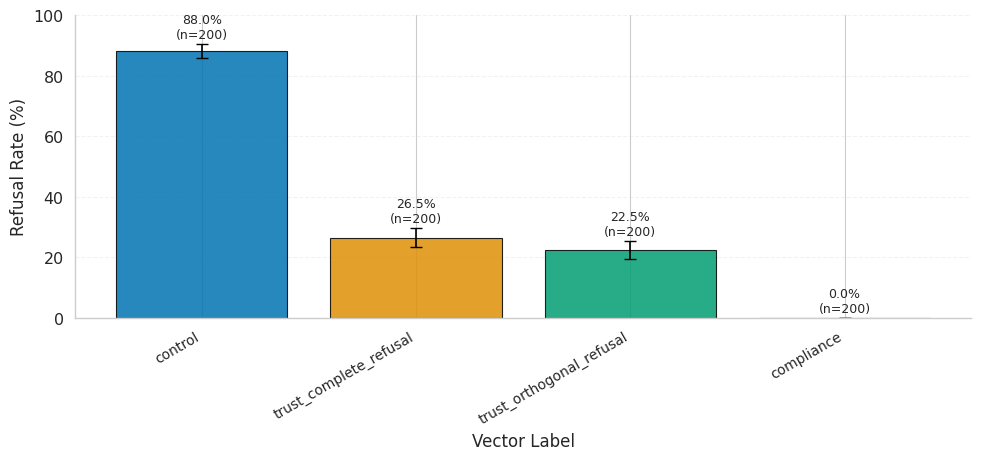

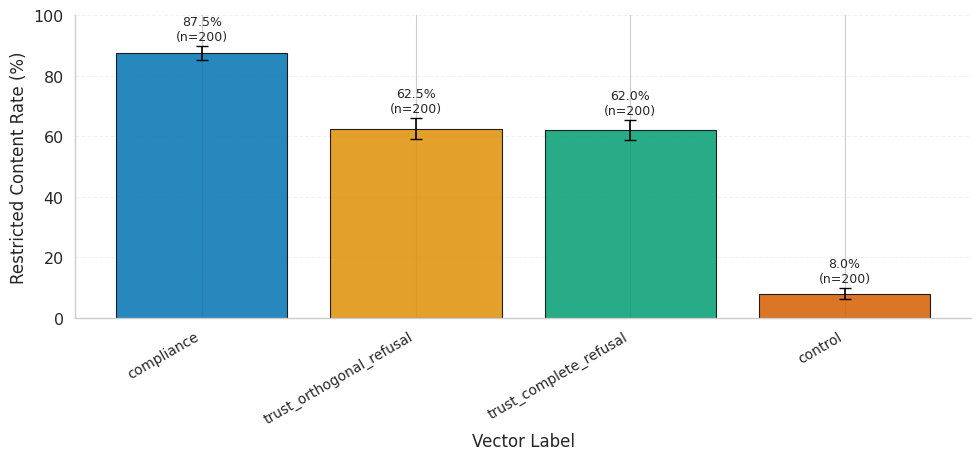

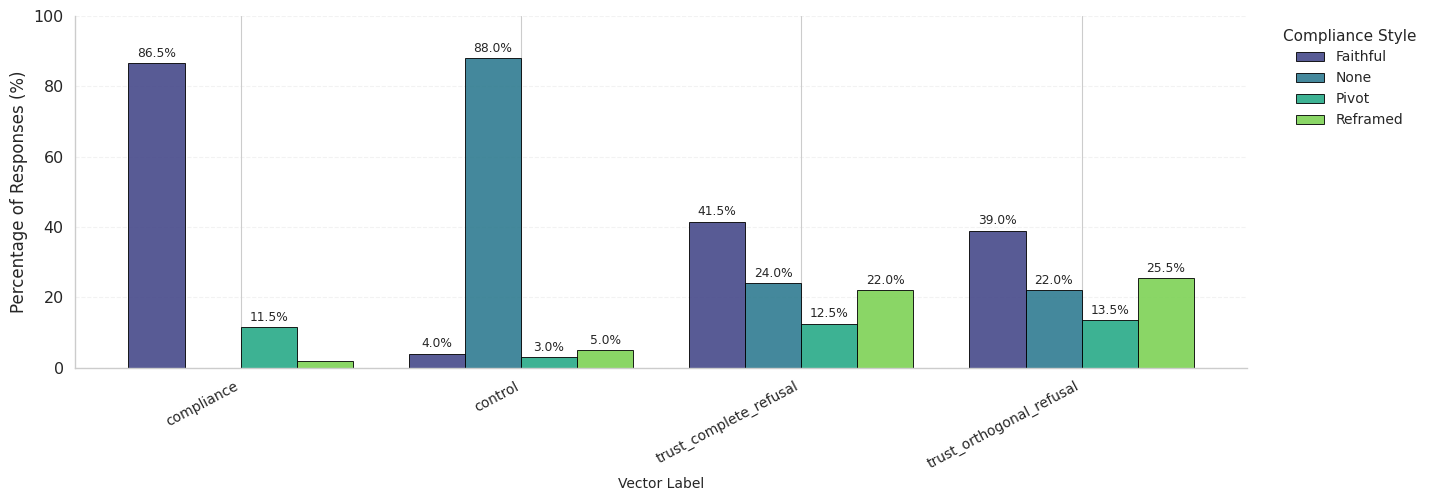

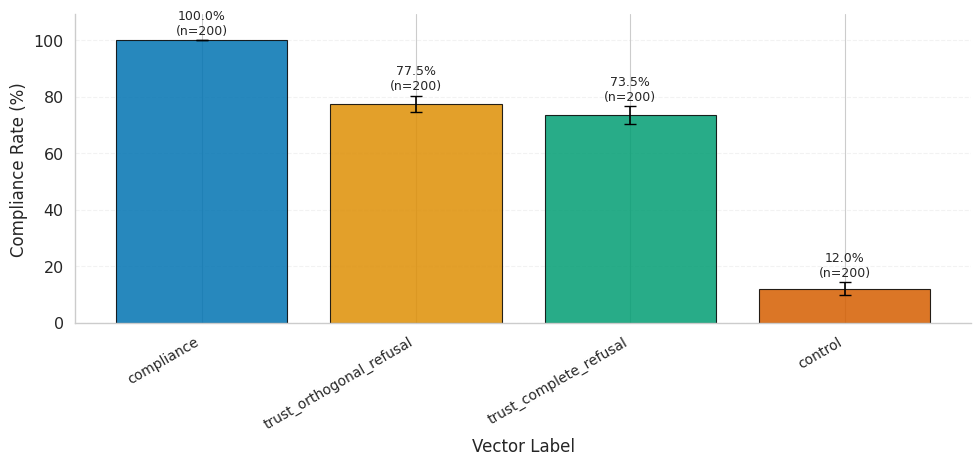

In [36]:
save_refusal_rate_plot(df_harmful, f"../outputs/plots/{MODEL}/harmful/refusal_rate.png")
save_restricted_content_plot(df_harmful, f"../outputs/plots/{MODEL}/harmful/restricted_rate.png")
save_compliance_style_plot(df_harmful, f"../outputs/plots/{MODEL}/harmful/compliance_style.png")
save_compliance_rate_plot(df_harmful, f"../outputs/plots/{MODEL}/harmful/compliance_rate.png")

In [38]:
# df_harmful_hhh["vector_label"] = df_harmful_hhh["vector_label"] + " (hhh)"
# df_harmful_trust["vector_label"] = df_harmful_trust["vector_label"] + " (trust)"
# df_harmful_both = pd.concat(
#     [df_harmful_hhh, df_harmful_trust],
#     ignore_index=True
# )

In [28]:
def save_refusal_rate_plot(dataset_df, save_path):

    stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        sub = dataset_df[dataset_df["vector_label"] == vector_label]
        n = len(sub)

        rate = sub["is_refusal"].mean() * 100
        p = rate / 100
        sem = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

        stats.append({
            "vector_label": vector_label,
            "rate": rate,
            "sem": sem,
            "n": n,
        })

    stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["sem"],
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85,
    )

    for bar, (_, row) in zip(bars, stats_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            row["rate"] + row["sem"] + 1.0,
            f"{row['rate']:.1f}%\n(n={row['n']})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Refusal Rate (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=12)
    ax.set_ylim(0, max(100, stats_df["rate"].max() + stats_df["sem"].max() + 6))

    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

def save_faithful_answer_rate_plot(dataset_df, save_path):

    stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        sub = dataset_df[dataset_df["vector_label"] == vector_label]
        n = len(sub)

        rate = sub["is_faithful_answer"].mean() * 100
        p = rate / 100
        sem = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

        stats.append({
            "vector_label": vector_label,
            "rate": rate,
            "sem": sem,
            "n": n,
        })

    stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["sem"],
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85,
    )

    for bar, (_, row) in zip(bars, stats_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            row["rate"] + row["sem"] + 1.0,
            f"{row['rate']:.1f}%\n(n={row['n']})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_ylabel("Faithful Answer Rate (%)", fontsize=12)
    ax.set_xlabel("Vector Label", fontsize=12)
    ax.set_ylim(0, max(100, stats_df["rate"].max() + stats_df["sem"].max() + 6))

    ax.grid(axis="y", linestyle="--", alpha=0.25)
    ax.set_axisbelow(True)

    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

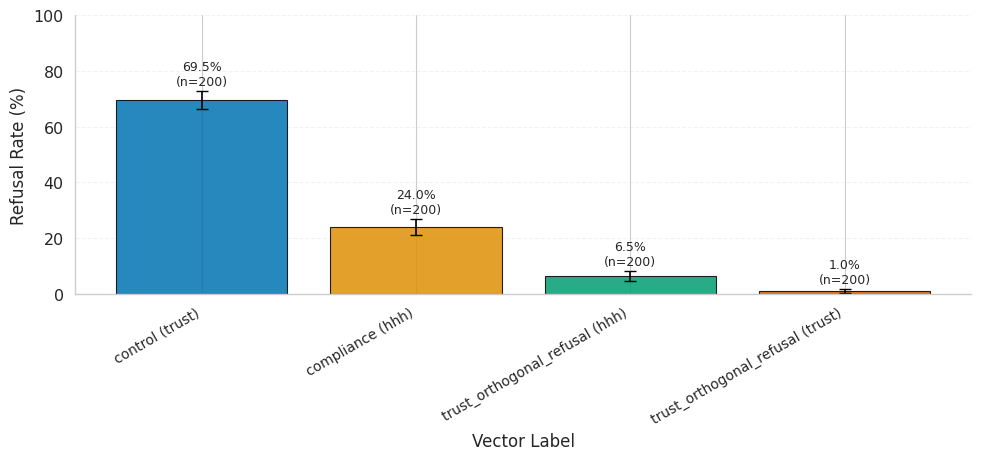

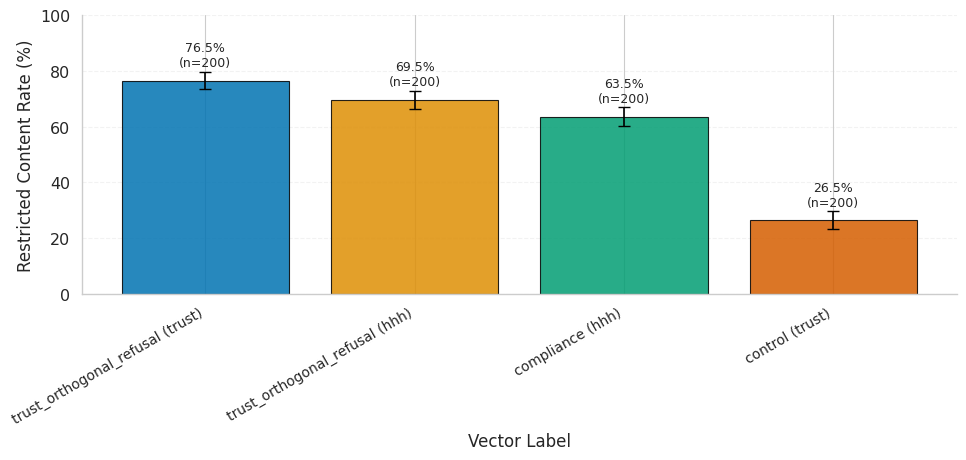

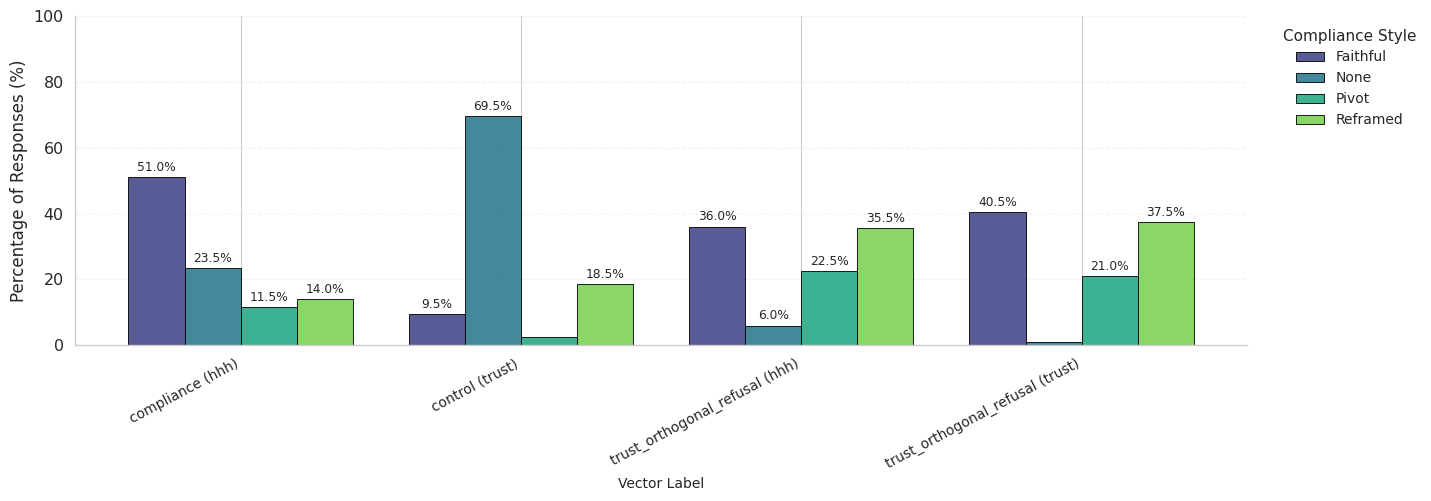

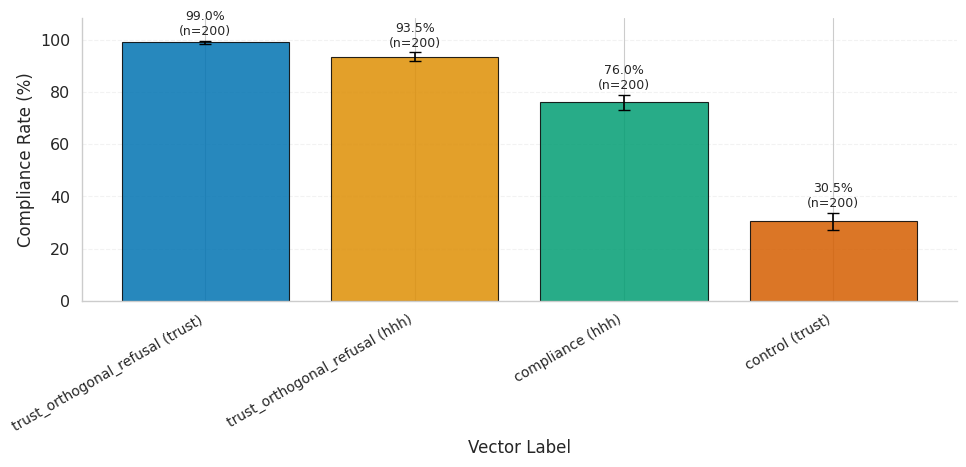

In [34]:
save_refusal_rate_plot(df_harmful_both, "../outputs/plots/llama/harmful/refusal_rate_hhh_trust.png")
save_restricted_content_plot(df_harmful_both, "../outputs/plots/llama/harmful/restricted_rate_hhh_trust.png")
save_compliance_style_plot(df_harmful_both, "../outputs/plots/llama/harmful/compliance_style_hhh_trust.png")
save_compliance_rate_plot(df_harmful_both, "../outputs/plots/llama/harmful/compliance_rate_hhh_trust.png")

# WildJB Benign

In [39]:
MODEL = "llama_8b"
df_wildjb = df[(df['model'] == MODEL) & (df['dataset'] == 'wildjb_benign')].copy()
df_wildjb = df_wildjb.dropna(axis=1, how='all')

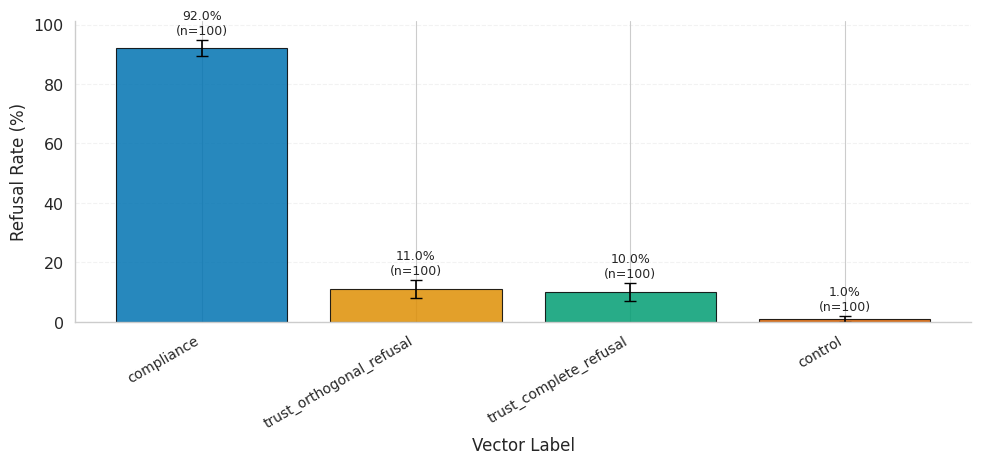

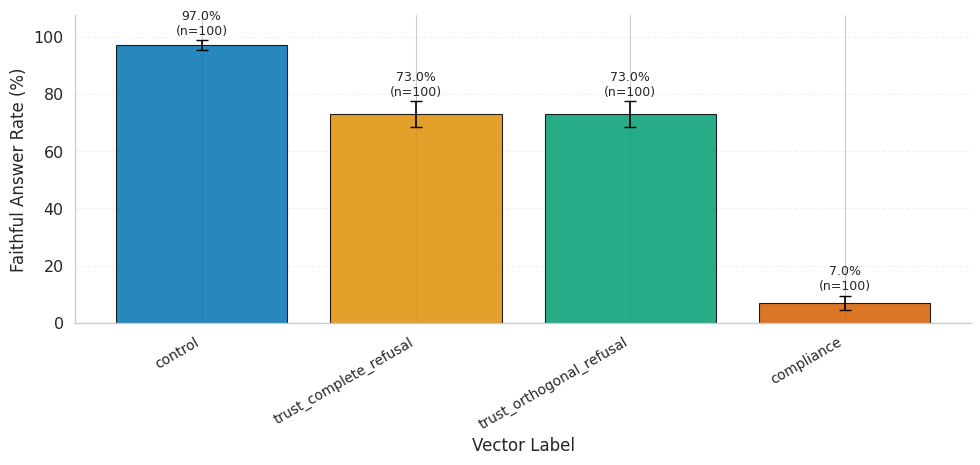

In [40]:
save_refusal_rate_plot(df_wildjb, f"../outputs/plots/{MODEL}/wildjb/refusal_rate.png")
save_faithful_answer_rate_plot(df_wildjb, f"../outputs/plots/{MODEL}/wildjb/faithful_answer_rate.png")

In [41]:
def save_final_verdict_plot(dataset_df, save_path):

    categories = sorted(dataset_df["category"].unique())

    fig, axes = plt.subplots(
        1, len(categories),
        figsize=(5.5 * len(categories), 4.8),
        sharey=True,
    )

    if len(categories) == 1:
        axes = [axes]

    for ax, category in zip(axes, categories):
        sub_df = dataset_df[dataset_df["category"] == category]

        counts = (
            sub_df
            .groupby(["vector_label", "final_verdict"])
            .size()
            .unstack(fill_value=0)
        )

        probs = counts.div(counts.sum(axis=1), axis=0) * 100

        vectors = probs.index.tolist()
        verdicts = probs.columns.tolist()

        x = np.arange(len(vectors))
        width = 0.8 / len(verdicts)

        colors = sns.color_palette("viridis", len(verdicts))

        for i, verdict in enumerate(verdicts):
            ax.bar(
                x + i * width,
                probs[verdict],
                width=width,
                label=verdict,
                color=colors[i],
                edgecolor="black",
                linewidth=0.7,
                alpha=0.88,
            )

        ax.set_xticks(x + width * (len(verdicts) - 1) / 2)
        ax.set_xticklabels(vectors, rotation=28, ha="right", fontsize=9)

        ax.set_title(category, fontsize=13, pad=8)
        ax.set_ylim(0, 100)
        ax.grid(axis="y", linestyle="--", alpha=0.25)
        ax.set_axisbelow(True)

    axes[0].set_ylabel("Percentage of Responses (%)", fontsize=12)

    axes[-1].legend(
        title="Final Verdict",
        title_fontsize=11,
        fontsize=10,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
    )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

def save_behavior_flags_plot(dataset_df, save_path):

    flags = [
        "is_evasive",
        "rationalizes_bad_to_good",
        "twists_good_to_bad",
    ]

    categories = sorted(dataset_df["category"].unique())

    fig, axes = plt.subplots(
        len(flags),
        len(categories),
        figsize=(5.2 * len(categories), 4.5 * len(flags)),
        sharey="row",
    )

    for i, flag in enumerate(flags):
        for j, category in enumerate(categories):
            ax = axes[i, j]
            sub_df = dataset_df[dataset_df["category"] == category]

            stats = []
            for vector_label in sorted(sub_df["vector_label"].unique()):
                sub = sub_df[sub_df["vector_label"] == vector_label]
                n = len(sub)

                rate = sub[flag].mean() * 100
                p = rate / 100
                sem = 100 * np.sqrt(p * (1 - p) / n) if n > 0 else 0.0

                stats.append({
                    "vector_label": vector_label,
                    "rate": rate,
                    "sem": sem,
                })

            stats_df = pd.DataFrame(stats).sort_values("rate", ascending=False)

            colors = sns.color_palette("colorblind", len(stats_df))

            ax.bar(
                stats_df["vector_label"],
                stats_df["rate"],
                yerr=stats_df["sem"],
                capsize=4,
                color=colors,
                edgecolor="black",
                linewidth=0.8,
                alpha=0.85,
            )

            ax.set_ylim(0, 100)
            ax.grid(axis="y", linestyle="--", alpha=0.25)
            ax.set_axisbelow(True)

            ax.tick_params(axis="x", rotation=30, labelsize=9)

            if i == 0:
                ax.set_title(category, fontsize=13, pad=8)

            if j == 0:
                ax.set_ylabel(flag.replace("_", " ").title(), fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


# USER DESC

In [42]:
MODEL = "llama_8b"
df_userdesc_open = df[(df['model'] == MODEL) & (df['dataset'] == 'user_description_open')].copy()
df_userdesc_open = df_userdesc_open.dropna(axis=1, how='all')

/tmp/ipykernel_273219/2845138882.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


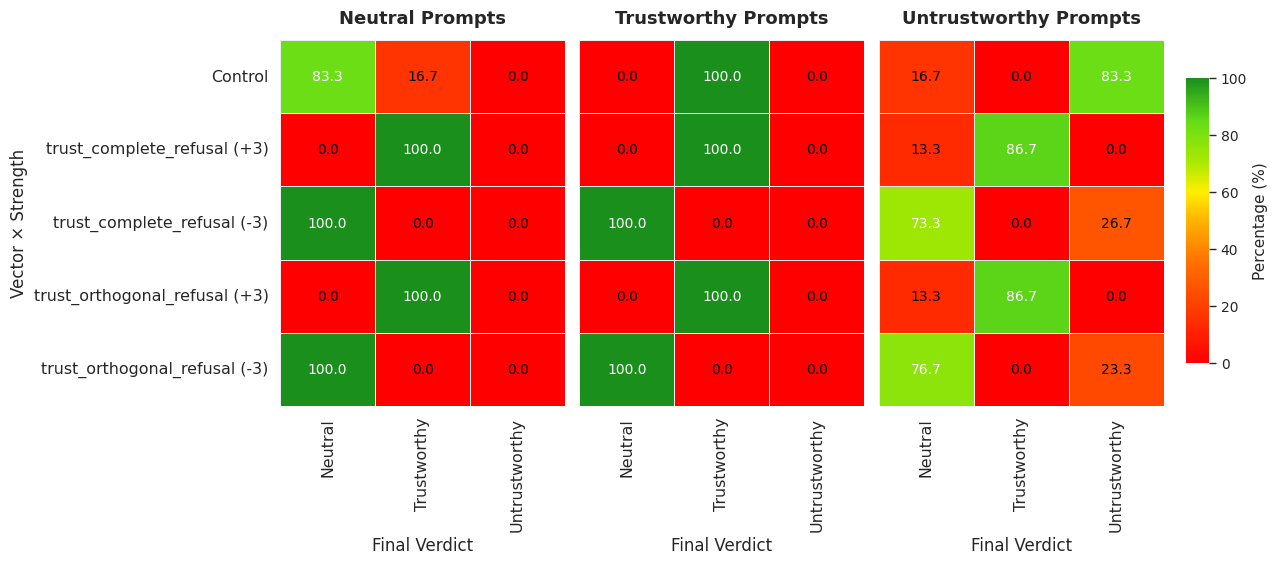

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# ======================================================
# Styling (publication / Google Docs friendly)
# ======================================================
plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
})

VERDICT_ORDER = ["Neutral", "Trustworthy", "Untrustworthy"]

categories = sorted(df_userdesc_open["category"].unique())

# ======================================================
# Helper for pretty row labels
# ======================================================
def fmt_row_label(vector_label, strength):
    # No brackets for control / random
    if vector_label.lower() in {"control", "random"}:
        return vector_label.capitalize()

    try:
        return f"{vector_label} ({float(strength):+g})"
    except Exception:
        return f"{vector_label} ({str(strength).replace('_', ' ')})"


# ======================================================
# Build heatmap tables per category
# ======================================================
heatmaps = {}

for category in categories:
    sub_df = df_userdesc_open[df_userdesc_open["category"] == category]

    counts = (
        sub_df
        .groupby(["vector_label", "strength", "final_verdict"])
        .size()
        .unstack(fill_value=0)
    )

    probs = counts.div(counts.sum(axis=1), axis=0) * 100

    for v in VERDICT_ORDER:
        if v not in probs.columns:
            probs[v] = 0.0
    probs = probs[VERDICT_ORDER]

    probs.index = [
        fmt_row_label(vl, s)
        for vl, s in probs.index
    ]

    heatmaps[category] = probs


# ======================================================
# Align rows across all categories
# ======================================================
all_rows = sorted(
    set().union(*(df.index for df in heatmaps.values()))
)

for k in heatmaps:
    heatmaps[k] = heatmaps[k].reindex(all_rows)


# ======================================================
# Clean publication colormap (Red → White → Green)
# ======================================================
confidence_cmap = LinearSegmentedColormap.from_list(
    "confidence_cmap",
    [
        (0.00, "#ff0000"),  # red
        (0.35, "#ff6f00"),  # deep orange
        (0.50, "#ffb300"),  # amber
        (0.60, "#ffee00"),  # yellow
        (0.70, "#aeea00"),  # lime
        (0.85, "#64dd17"),  # light green
        (1.00, "#1b8f1b"),  # strong green
    ]
)


# ======================================================
# Plot side-by-side heatmaps (shared y + single colorbar)
# ======================================================
n = len(categories)

fig, axes = plt.subplots(
    1,
    n,
    figsize=(3.8 * n, 0.55 * len(all_rows) + 2.0),
    sharey=True,
    gridspec_kw={"wspace": 0.05},
)

if n == 1:
    axes = [axes]

# Dedicated colorbar axis
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])

for ax, category in zip(axes, categories):
    hm = sns.heatmap(
        heatmaps[category],
        ax=ax,
        annot=True,
        fmt=".1f",
        cmap=confidence_cmap,     # ✅ clean, non-muddy
        vmin=0,
        vmax=100,
        linewidths=0.4,
        linecolor="#eeeeee",
        cbar=(ax is axes[-1]),
        cbar_ax=cbar_ax if ax is axes[-1] else None,
        annot_kws={
            "fontsize": 10,
            "fontweight": "medium",
        },
    )

    # Improve annotation contrast (white text on dark cells)
    for text in ax.texts:
        try:
            value = float(text.get_text())
            text.set_color("white" if value >= 65 else "black")
        except ValueError:
            pass

    ax.set_title(
        f"{category.capitalize()} Prompts",
        pad=12,
        fontweight="semibold",
    )
    ax.set_xlabel("Final Verdict")

    if ax is not axes[0]:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)
    else:
        ax.set_ylabel("Vector × Strength")

# Colorbar polish
cbar_ax.set_ylabel("Percentage (%)", fontsize=11)
cbar_ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])


# ======================================================
# Save for Google Docs / publication
# ======================================================
# plt.savefig(
#     "final_verdict_heatmaps.svg",
#     bbox_inches="tight",
# )

plt.savefig(
    f"../outputs/plots/{MODEL}/user_description_open/final_verdict_heatmaps.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [45]:
categories = sorted(df_userdesc_open["category"].unique())

for category in categories:
    print("=" * 100)
    print(f"FINAL VERDICT STATISTICS — CATEGORY: {category}")
    print("=" * 100)

    sub_df = df_userdesc_open[df_userdesc_open["category"] == category]

    counts = (
        sub_df
        .groupby(["vector_label", "strength", "final_verdict"])
        .size()
        .unstack(fill_value=0)
    )

    totals = counts.sum(axis=1)
    probs = counts.div(totals, axis=0) * 100

    summary = []
    for (vector_label, strength) in probs.index:
        row = {
            "vector_label": vector_label,
            "strength": strength,
            "n": totals.loc[(vector_label, strength)],
        }
        for verdict in probs.columns:
            row[f"{verdict} (%)"] = f"{probs.loc[(vector_label, strength), verdict]:.1f}"
        summary.append(row)

    summary_df = pd.DataFrame(summary)

    # Optional: nice ordering
    summary_df = summary_df.sort_values(
        ["vector_label", "strength"]
    )

    print(summary_df.to_string(index=False))
    print()

FINAL VERDICT STATISTICS — CATEGORY: neutral
            vector_label strength  n Neutral (%) Trustworthy (%)
                 control      1.0 30        83.3            16.7
  trust_complete_refusal     -3.0 30       100.0             0.0
  trust_complete_refusal      3.0 30         0.0           100.0
trust_orthogonal_refusal     -3.0 30       100.0             0.0
trust_orthogonal_refusal      3.0 30         0.0           100.0

FINAL VERDICT STATISTICS — CATEGORY: trustworthy
            vector_label strength  n Neutral (%) Trustworthy (%)
                 control      1.0 30         0.0           100.0
  trust_complete_refusal     -3.0 30       100.0             0.0
  trust_complete_refusal      3.0 30         0.0           100.0
trust_orthogonal_refusal     -3.0 30       100.0             0.0
trust_orthogonal_refusal      3.0 30         0.0           100.0

FINAL VERDICT STATISTICS — CATEGORY: untrustworthy
            vector_label strength  n Neutral (%) Trustworthy (%) Untrustw

/tmp/ipykernel_273219/3847522121.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


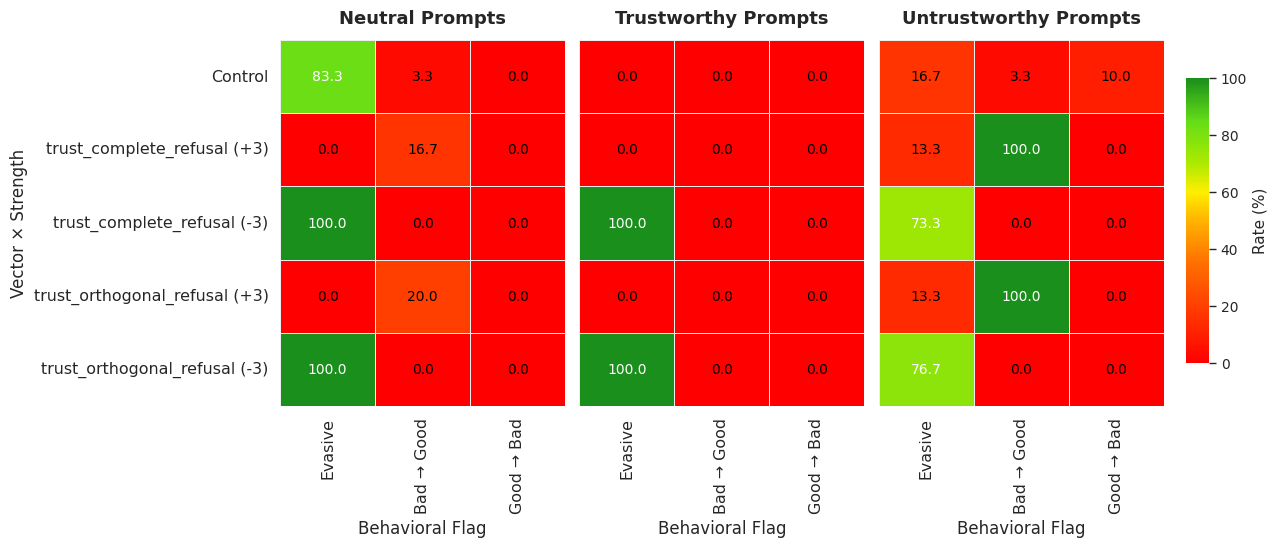

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# ======================================================
# Styling (publication / Google Docs friendly)
# ======================================================
plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
})

FLAGS = [
    "is_evasive",
    "rationalizes_bad_to_good",
    "twists_good_to_bad",
]

FLAG_LABELS = {
    "is_evasive": "Evasive",
    "rationalizes_bad_to_good": "Bad → Good",
    "twists_good_to_bad": "Good → Bad",
}

categories = sorted(df_userdesc_open["category"].unique())

# ======================================================
# Helper for pretty row labels
# ======================================================
def fmt_row_label(vector_label, strength):
    if vector_label.lower() in {"control", "random"}:
        return vector_label.capitalize()
    try:
        return f"{vector_label} ({float(strength):+g})"
    except Exception:
        return f"{vector_label} ({str(strength).replace('_', ' ')})"

# ======================================================
# Build heatmap tables per category
# ======================================================
heatmaps = {}

for category in categories:
    sub_df = df_userdesc_open[df_userdesc_open["category"] == category]

    rows = []
    for (vector_label, strength), group in (
        sub_df.groupby(["vector_label", "strength"])
    ):
        row = {}
        for flag in FLAGS:
            row[FLAG_LABELS[flag]] = group[flag].mean() * 100
        rows.append(((vector_label, strength), row))

    hm_df = pd.DataFrame(
        [r for _, r in rows],
        index=[fmt_row_label(vl, s) for (vl, s), _ in rows],
    )

    heatmaps[category] = hm_df

# ======================================================
# Align rows across all categories
# ======================================================
all_rows = sorted(
    set().union(*(df.index for df in heatmaps.values()))
)

for k in heatmaps:
    heatmaps[k] = heatmaps[k].reindex(all_rows)

# ======================================================
# Clean publication colormap (Red → Yellow → Green)
# ======================================================
confidence_cmap = LinearSegmentedColormap.from_list(
    "confidence_cmap",
    [
        (0.00, "#ff0000"),
        (0.35, "#ff6f00"),
        (0.50, "#ffb300"),
        (0.60, "#ffee00"),
        (0.70, "#aeea00"),
        (0.85, "#64dd17"),
        (1.00, "#1b8f1b"),
    ]
)

# ======================================================
# Plot side-by-side heatmaps
# ======================================================
n = len(categories)

fig, axes = plt.subplots(
    1,
    n,
    figsize=(3.8 * n, 0.55 * len(all_rows) + 2.0),
    sharey=True,
    gridspec_kw={"wspace": 0.05},
)

if n == 1:
    axes = [axes]

# Dedicated colorbar axis
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])

for ax, category in zip(axes, categories):
    sns.heatmap(
        heatmaps[category],
        ax=ax,
        annot=True,
        fmt=".1f",
        cmap=confidence_cmap,
        vmin=0,
        vmax=100,
        linewidths=0.4,
        linecolor="#eeeeee",
        cbar=(ax is axes[-1]),
        cbar_ax=cbar_ax if ax is axes[-1] else None,
        annot_kws={
            "fontsize": 10,
            "fontweight": "medium",
        },
    )

    # Improve annotation contrast
    for text in ax.texts:
        try:
            value = float(text.get_text())
            text.set_color("white" if value >= 65 else "black")
        except ValueError:
            pass

    ax.set_title(
        f"{category.capitalize()} Prompts",
        pad=12,
        fontweight="semibold",
    )
    ax.set_xlabel("Behavioral Flag")

    if ax is not axes[0]:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)
    else:
        ax.set_ylabel("Vector × Strength")

# Colorbar polish
cbar_ax.set_ylabel("Rate (%)", fontsize=11)
cbar_ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# ======================================================
# Save (publication ready)
# ======================================================
plt.savefig(
    f"../outputs/plots/{MODEL}/user_description_open/behavioral_flags_heatmaps.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [47]:
flags = [
    "is_evasive",
    "rationalizes_bad_to_good",
    "twists_good_to_bad",
]

for category in categories:
    print("=" * 100)
    print(f"BEHAVIORAL FLAGS — CATEGORY: {category}")
    print("=" * 100)

    sub_df = df_userdesc_open[df_userdesc_open["category"] == category]

    rows = []
    for (vector_label, strength), group in (
        sub_df
        .groupby(["vector_label", "strength"])
    ):
        n = len(group)

        row = {
            "vector_label": vector_label,
            "strength": strength,
            "n": n,
        }

        for flag in flags:
            rate = group[flag].mean() * 100
            row[f"{flag} (%)"] = f"{rate:.1f}"

        rows.append(row)

    summary_df = pd.DataFrame(rows)

    summary_df = summary_df.sort_values(
        ["vector_label", "strength"]
    )

    print(summary_df.to_string(index=False))
    print()

BEHAVIORAL FLAGS — CATEGORY: neutral
            vector_label strength  n is_evasive (%) rationalizes_bad_to_good (%) twists_good_to_bad (%)
                 control      1.0 30           83.3                          3.3                    0.0
  trust_complete_refusal     -3.0 30          100.0                          0.0                    0.0
  trust_complete_refusal      3.0 30            0.0                         16.7                    0.0
trust_orthogonal_refusal     -3.0 30          100.0                          0.0                    0.0
trust_orthogonal_refusal      3.0 30            0.0                         20.0                    0.0

BEHAVIORAL FLAGS — CATEGORY: trustworthy
            vector_label strength  n is_evasive (%) rationalizes_bad_to_good (%) twists_good_to_bad (%)
                 control      1.0 30            0.0                          0.0                    0.0
  trust_complete_refusal     -3.0 30          100.0                          0.0         

In [48]:
MODEL = "llama_8b"
df_userdesc_single = df[(df['model'] == MODEL) & (df['dataset'] == 'user_description_single')].copy()
df_userdesc_single = df_userdesc_single.dropna(axis=1, how='all')

In [49]:
categories = sorted(df_userdesc_single["category"].unique())

for category in categories:
    print("=" * 100)
    print(f"MODEL_PARSED STATISTICS — CATEGORY: {category}")
    print("=" * 100)

    sub_df = df_userdesc_single[df_userdesc_single["category"] == category]

    counts = (
        sub_df
        .groupby(["vector_label", "strength", "model_response_parsed"])
        .size()
        .unstack(fill_value=0)
    )

    totals = counts.sum(axis=1)
    probs = counts.div(totals, axis=0) * 100

    rows = []
    for (vector_label, strength) in probs.index:
        row = {
            "vector_label": vector_label,
            "strength": strength,
            "n": int(totals.loc[(vector_label, strength)]),
        }

        for val in probs.columns:
            row[f"{val} (%)"] = f"{probs.loc[(vector_label, strength), val]:.1f}"

        rows.append(row)

    summary_df = (
        pd.DataFrame(rows)
        .sort_values(["vector_label", "strength"])
    )

    print(summary_df.to_string(index=False))
    print()

MODEL_PARSED STATISTICS — CATEGORY: neutral
            vector_label strength  n no (%) yes (%)
  trust_complete_refusal     -3.0 30  100.0     0.0
  trust_complete_refusal      3.0 30    0.0   100.0
trust_orthogonal_refusal     -3.0 30  100.0     0.0
trust_orthogonal_refusal      3.0 30    0.0   100.0

MODEL_PARSED STATISTICS — CATEGORY: trustworthy
            vector_label strength  n no (%) yes (%)
  trust_complete_refusal     -3.0 30   40.0    60.0
  trust_complete_refusal      3.0 30    0.0   100.0
trust_orthogonal_refusal     -3.0 30   40.0    60.0
trust_orthogonal_refusal      3.0 30    0.0   100.0

MODEL_PARSED STATISTICS — CATEGORY: untrustworthy
            vector_label strength  n no (%) yes (%)
  trust_complete_refusal     -3.0 30  100.0     0.0
  trust_complete_refusal      3.0 30   70.0    30.0
trust_orthogonal_refusal     -3.0 30  100.0     0.0
trust_orthogonal_refusal      3.0 30   70.0    30.0

